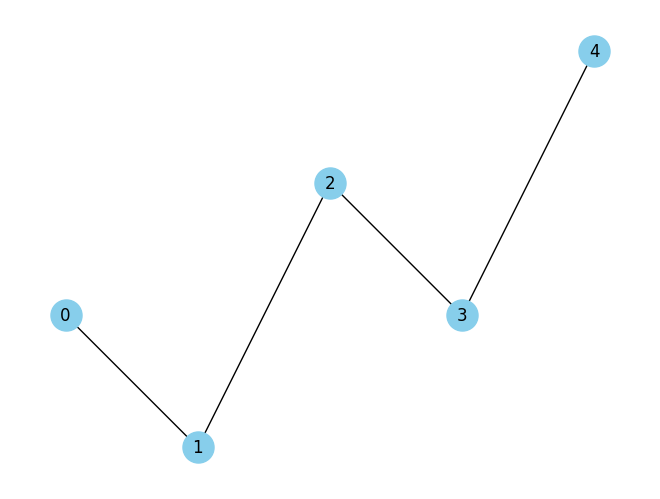

In [1]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data

# dummydata: Assume we have a simple pose with 5 joints and their coordinates.
joint_positions = torch.tensor([
    [0.1, 0.5],  #(left shoulder)
    [0.2, 0.4],  #(left elbow)
    [0.3, 0.6],  #(right shoulder)
    [0.4, 0.5],  #(right elbow)
    [0.5, 0.7],  #(head)
], dtype=torch.float)


edge_index = torch.tensor([
    [0, 1],  # left shoulder to left elbow
    [1, 2],  # left elbow to right shoulder
    [2, 3],  # right shoulder to right elbow
    [3, 4],  # right elbow to head
], dtype=torch.long).t().contiguous()


data = Data(x=joint_positions, edge_index=edge_index)

#visualize the graph
G = nx.Graph()
for i in range(joint_positions.size(0)):
    G.add_node(i, pos=joint_positions[i].tolist())
for edge in edge_index.t().tolist():
    G.add_edge(edge[0], edge[1])

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue")
plt.show()


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

#defining the model
class PoseGNN(torch.nn.Module):
    def __init__(self):
        super(PoseGNN, self).__init__()
        #two GCN layers
        self.conv1 = GCNConv(2, 16)  #input:2D coordinates (x, y), output:16 features
        self.conv2 = GCNConv(16, 2)  #output layer with 2 features per node

    def forward(self, data):        
        x, edge_index = data.x, data.edge_index #convolution layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)  #activation function
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


model = PoseGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() 

model.train()
optimizer.zero_grad()
out = model(data)
loss = criterion(out, data.x)  #here, we just try to predict the input data itself
loss.backward()
optimizer.step()

print("Output after one training step:", out)

"""
the output is such that the model predicts the location of each node. 
 """


Output after one training step: tensor([[-0.6015, -0.7940],
        [-0.5759, -0.8260],
        [-0.5898, -0.8084],
        [-0.5876, -0.8111],
        [-0.5762, -0.8256]], grad_fn=<LogSoftmaxBackward0>)


'\nthe output is such that the model predicts the location of each node. \n '

### If you are using this on a macbook, remember to open this in a virtual environment and run it there.


1. pip install torch torchvision torchaudio
2. pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric
3. pip install networkx
4. pip install matplotlib